## Inspect crab escape trajectories using `movement`.

### Requirements
1. Create and activate a conda environment with `movement` by following the 
   instructions at https://movement.neuroinformatics.dev/getting_started/installation.html

2. Install some additional dependencies on the conda environment by running:
      ```
      pip install ipykernel ipympl
      ```

3. Mount the zoo directory in ceph following the guide at
   https://howto.neuroinformatics.dev/programming/Mount-ceph-ubuntu-temp.html


### Import required packages

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from movement.io import load_bboxes

Uncomment and run the following line to enable interactive plots

In [ ]:
# %matplotlib widget

### Set input and output data

In [ ]:
# Ensure the input data points to the directory containing the 
# csv files in ceph
input_data = Path(
    "/ceph/zoo/users/sminano/escape_clips_tracking_output_slurm_5699097"
    
)

Set output directory for figures

In [ ]:
output_figures_dir = "path/to/directory/where/figures/will/be/saved"  
# replace with actual path

# Create output directory if it doesnt exist
if not output_figures_dir.exists():
    output_figures_dir.mkdir(parents=True)

List all .csv files in the input directory

In [5]:
list_csv_files = [
    x
    for x in input_data.iterdir()
    if x.is_file() and x.name.endswith("_tracks.csv")
]
list_csv_files.sort()
print(len(list_csv_files))

234


### Read first file as movement dataset

In [6]:
csv_file = list_csv_files[0]

ds = load_bboxes.from_via_tracks_file(
    csv_file, fps=None, use_frame_numbers_from_file=False
)

Print summary metrics of dataset

In [7]:
print(Path(ds.source_file).name)
print(f"Number of frames: {ds.sizes['time']}")
print(f"Number of individuals: {ds.sizes['individuals']}")
print(ds)
print("--------------------")

04.09.2023-01-Right-Spontaneous1_tracks.csv
Number of frames: 187
Number of individuals: 105
<xarray.Dataset> Size: 789kB
Dimensions:      (time: 187, individuals: 105, space: 2)
Coordinates:
  * time         (time) int64 1kB 0 1 2 3 4 5 6 ... 180 181 182 183 184 185 186
  * individuals  (individuals) <U6 3kB 'id_1' 'id_2' ... 'id_105' 'id_107'
  * space        (space) <U1 8B 'x' 'y'
Data variables:
    position     (time, individuals, space) float64 314kB 3.285e+03 ... 119.5
    shape        (time, individuals, space) float64 314kB 46.0 58.0 ... 33.0
    confidence   (time, individuals) float64 157kB 0.6846 0.7115 ... 0.9999 1.0
Attributes:
    fps:              None
    time_unit:        frames
    source_software:  VIA-tracks
    source_file:      /home/sminano/swc/project_crabs/escape_clips_tracking_o...
    ds_type:          bboxes
--------------------


### Prepare histogram metrics

For each ID, compute the number of frames for which the centroid position has non-nan x,y coordinates

In [8]:
non_nan_frames_per_ID = {}
for ind, _id_str in enumerate(ds.individuals):
    non_nan_frames_per_ID[ind] = (
        len(ds.time) - ds.position[:, ind, :].isnull().any(axis=1).sum().item()
    )

### Prepare plots

In [9]:
# select whether to plot ID at first frame
flag_plot_id = False

# Define colors - ideally more than max n individuals
# so that we don't have repetitions
list_colors = (
    plt.get_cmap("Pastel1").colors  # 9 colors
    + plt.get_cmap("Pastel2").colors  # 8 colors
    + plt.get_cmap("Paired").colors  # 12 colors
    + plt.get_cmap("Accent").colors  # 8 colors
    + plt.get_cmap("Dark2").colors  # 8 colors
    + plt.get_cmap("Set1").colors  # 9 colors
    + plt.get_cmap("Set3").colors  # 12 colors
    + plt.get_cmap("tab20b").colors  # 10 colors
    + plt.get_cmap("tab20c").colors  # 20 colors
)  # 96 colors

### Plot trajectories and colour by individual

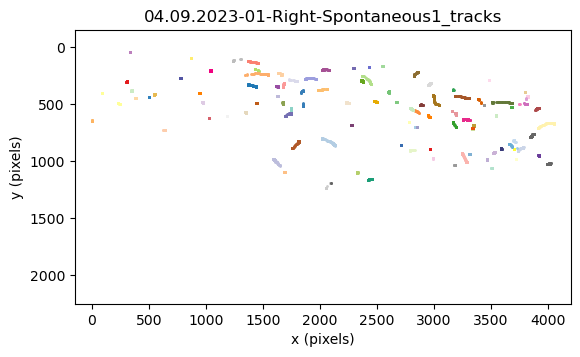

In [10]:
fig, ax = plt.subplots(1, 1)
for ind_idx in range(ds.sizes["individuals"]):
    # plot trajectories
    ax.scatter(
        x=ds.position[:, ind_idx, 0],  # nframes, nindividuals, x
        y=ds.position[:, ind_idx, 1],
        s=1,
        color=list_colors[ind_idx % len(list_colors)],
    )
    # add ID at first frame with non-nan x-coord
    if flag_plot_id:
        start_frame = ds.time[~ds.position.isnull()[:, ind_idx, 0]][0].item()
        ax.text(
            x=ds.position[start_frame, ind_idx, 0],
            y=ds.position[start_frame, ind_idx, 1],
            s=ds.individuals[ind_idx].item().split("_")[1],
            fontsize=8,
            color=list_colors[ind_idx % len(list_colors)],
        )

ax.set_aspect("equal")
ax.set_xlim(-150, 4200)  # frame size: 4096x2160
ax.set_ylim(-150, 2250)  # frame size: 4096x2160
ax.set_xlabel("x (pixels)")
ax.set_ylabel("y (pixels)")
ax.set_title(Path(ds.source_file).stem)
ax.invert_yaxis()

# Save plot as png
plt.savefig(
    output_figures_dir / f"{Path(ds.source_file).stem}_tracks.png",
    dpi=300,
    bbox_inches="tight",
)

### Plot histogram of trajectories' lengths

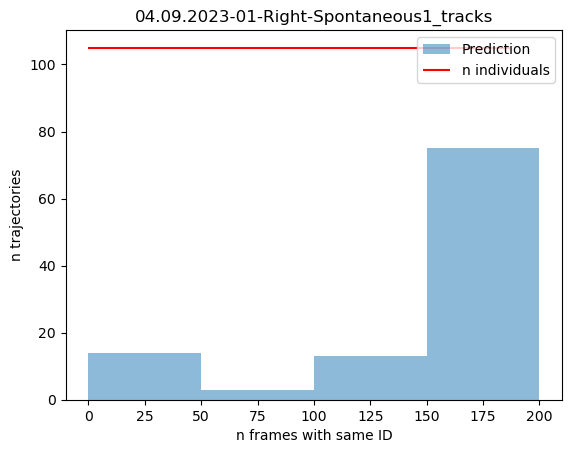

In [11]:
fig, ax = plt.subplots(1, 1)
ax.hist(
    non_nan_frames_per_ID.values(),
    bins=np.arange(0, len(ds.time) + 50, 50),
    alpha=0.5,
    label="Prediction",
)
ax.set_xlabel("n frames with same ID")
ax.set_ylabel("n trajectories")
ax.hlines(
    y=len(ds.individuals),
    xmin=0,
    xmax=len(ds.time),
    color="red",
    label="n individuals",
)
ax.legend()
ax.set_title(Path(ds.source_file).stem)

# Save plot as png
plt.savefig(
    output_figures_dir / f"{Path(ds.source_file).stem}_histogram.png",
    dpi=300,
    bbox_inches="tight",
)